In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer

#Modele de prediction
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#Modeles  de machine learning
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression,ElasticNet, Ridge, Lasso

#Indicateurs des performances du modele 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import shap
import time

import lime
from lime import lime_tabular
import random


## Fonctions

In [3]:
# fonction qui remove les colonnes 
def remove_column(df,columns):
    df.drop(labels=columns,axis=1, inplace= True)

In [4]:
# fonction qui efface les lignes aves des valeurs Nan
def imputation(df):
    return df.dropna(axis=0)

In [5]:

def ohe(df,labels):
    ohe = OneHotEncoder()
    feature_arry=ohe.fit_transform(df[[labels]]).toarray()
    feature_labels=ohe.categories_
    features =pd.DataFrame(feature_arry, columns=feature_labels)
    return features

In [6]:
# fonction qui transforme les variables de type quantitave dans un tableau des valeurs qualitatives 
def labels(df, labels):
    le = LabelEncoder()
    le.fit(df[labels])
    val =le.transform(df[labels])
    remove_column(df,labels)
    df = pd.concat(
        [df, pd.DataFrame(val,columns=[labels])], axis=1)
    return df

In [7]:
# fonction qui applique la methode LabelEncoder aux variables 
def knn_imputer(df,k):

    imputer = KNNImputer(n_neighbors=k)
    After_imputation = imputer.fit_transform(df)
    df = pd.DataFrame(After_imputation,columns = df.columns)

    return df

In [8]:
# fonction qui complete les valeurs manquantes du dataframe avec la methode des k plus proches voisins 
def preprocessing(data,labels):
    
    X = data.drop([labels],axis=1)
    y = data[labels]
    
    return X,y

In [9]:
# fonction qui renvoi les characteristiques du modele de prediction
def characteristic(y_test,y_predict):
    
    R2=r2_score(y_test,y_predict)
    MCE=mean_squared_error(y_test,y_predict)
    RMCE=np.sqrt(mean_squared_error(y_test,y_predict))
    MAE=median_absolute_error(y_test,y_predict)
    
    return R2,MCE,RMCE,MAE

In [10]:
# fonction qui rempli et organise le tableau des modeles selon la valeur R2
def df_score(df_scores,modele, R2, RMCE, MAE):
    df_scores.loc[df_scores.shape[0]] = [modele, R2, RMCE, MAE]
    df_scores.sort_values(by='R2', ascending=False, inplace=True)
    df_scores.drop_duplicates(subset=['modele'], keep='last', inplace=True)
    df_scores.reset_index(drop=True, inplace=True)
    
    return df_scores

In [11]:
# fonction qui entraine les modeles et renvoi les valeurs du tableau 
def model_evaluation(modele,df_scores):
     
    modele.fit(X_train, y_train)
    y_predict=modele.predict(X_test)
    
    R2,MCE,RMCE,MAE=characteristic(y_test,y_predict)
    df_score(df_scores,modele, R2, RMCE, MAE)
          
    return df_scores

In [12]:
# fonction qui renvoi le temps d'entrainement des modeles 
def train_model(model): 
   
    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time
  
    train_accuracy =  pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test) 
    model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
    return model_details

In [13]:
# fonction qui applique la cross validation, fonction utilisé pour tester la robustesse 
def validation_croise(model,X, y):
    score = cross_val_score(model, X, y, cv=5 ,scoring='r2')
    return score

In [14]:
# fonction qui renvoi les meilleurs hyperparametres des modeles, il rempli aussi un table avec les differents scores du model
def hyperparameter(df_scores,modele,parametre):
    
    recherche_hyper=GridSearchCV(modele,parametre,cv=5,scoring='r2')
    recherche_hyper.fit(X_train, y_train)
    y_predict = recherche_hyper.predict(X_test)
    
    print(modele,recherche_hyper.best_params_)

    R2,MCE,RMCE,MAE=characteristic(y_test,y_predict)
    recherche_hyper=df_score(df_scores,modele, R2, RMCE, MAE)
    return recherche_hyper

# Modele de Prediction

In [15]:
df=pd.read_csv('building-energy-cleaned.csv')

In [16]:
remove_column(df,'BuildingType')

## 1) Etude de l'emission de CO2 sans la variable ENERGYSTARScore

### 1.1) Encodage 

In [17]:
categorical = df.select_dtypes('object')
for col in categorical:
        df=labels(df,col)

In [18]:
df_test=df.copy()
df_test=df_test.dropna(axis = 0)
remove_column(df_test,'ENERGYSTARScore')

Dans la partie 1 ont a vu qu'il y avais des données qui sont tres correlés entres elle par exemple SteamUse, NaturalGas et SiteEnergyUse, si on prend en compte ses valeurs dans nos predictions, elles ne serons pas realistes car on apporterait les solutions a la prediction, c'est pour cela que ces variables seron effacé. Pour la variable HistoricalPeriod, ayant deja une variable qui apportent des information par rapport au temps, on tiendra pas compte de cette variable. La variable BuildingRate n'etant pas tres corrélés avec les variables a predire, l'information qu'elle nous apporterait n'aura pas beaucoup d'influence.

In [19]:
remove_column(df_test,['SiteEnergyUse','SteamUse','NaturalGas','BuildingRate','HistoricalPeriod'])

### 1.2) Standardisation 

In [20]:
column=df_test.columns.values
scaler = MinMaxScaler()
scaler.fit(df_test)
df_np=scaler.transform(df_test)
labels=df_test.columns

In [21]:
df_test=pd.DataFrame(df_np,columns=column)

### 1.3) Echantillonage

In [22]:
trainset, testset = train_test_split(df_test, test_size=0.2, random_state=0)

In [23]:
X_train, y_train = preprocessing(trainset,'TotalGHGEmissions')

In [24]:
X_test, y_test = preprocessing(testset,'TotalGHGEmissions')

### 1.4) Evaluation des hyperparametres

In [25]:
score=[]
df_scores = pd.DataFrame(score, columns=['modele', 'R2', 'RMSE', 'MAE'])

In [26]:
parametre_LR ={}
hyperparameter(df_scores,LinearRegression(),parametre_LR)

LinearRegression() {}


,modele,R2,RMSE,MAE
0,LinearRegression(),-0.866033,0.033779,0.005488


In [27]:
parametre_Lasso={}
hyperparameter(df_scores,Lasso(),parametre_Lasso)

Lasso() {}


,modele,R2,RMSE,MAE
0,Lasso(),-0.030775,0.025105,0.011992
1,LinearRegression(),-0.866033,0.033779,0.005488


In [28]:
parametre_Ridge={}
hyperparameter(df_scores,Ridge(),parametre_Ridge)

Ridge() {}


,modele,R2,RMSE,MAE
0,Ridge(),0.014044,0.024554,0.006027
1,Lasso(),-0.030775,0.025105,0.011992
2,LinearRegression(),-0.866033,0.033779,0.005488


In [29]:
parametre_EN={"max_iter": [1, 5, 10], "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": np.arange(0.0, 1.0, 0.1)}
hyperparameter(df_scores,ElasticNet(),parametre_EN)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.193e-01, tolerance: 2.056e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.536e-01, tolerance: 2.405e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.720e-01, tolerance: 2.719e-04 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.972e-03, tolerance: 1.661e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-03, tolerance: 2.829e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.160e-01, tolerance: 2.056e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.457e-01, tolerance: 2.405e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.715e-01, tolerance: 2.719e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e-01, tolerance: 1.661e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.667e-01, tolerance: 2.829e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.540e-01, tolerance: 2.056e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 2.405e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 2.719e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.527e-04, tolerance: 2.056e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.003e-04, tolerance: 2.405e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-03, tolerance: 2.719e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.926e-04, tolerance: 1.661e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.474e-04, tolerance: 2.829e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.398e-02, tolerance: 1.661e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 2.829e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.828e-04, tolerance: 2.056e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e-03, tolerance: 2.405e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e-02, tolerance: 2.719e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.711e-02, tolerance: 2.719e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-02, tolerance: 1.661e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.444e-02, tolerance: 2.829e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-03, tolerance: 2.056e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-03, tolerance: 2.405e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e+00, tolerance: 2.056e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+00, tolerance: 2.405e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e+00, tolerance: 2.719e-04 Linear regression models with null weig

ElasticNet() {'alpha': 0.001, 'l1_ratio': 0.1, 'max_iter': 5}


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.299e-02, tolerance: 2.918e-04


,modele,R2,RMSE,MAE
0,ElasticNet(),0.118132,0.023221,0.005265
1,Ridge(),0.014044,0.024554,0.006027
2,Lasso(),-0.030775,0.025105,0.011992
3,LinearRegression(),-0.866033,0.033779,0.005488


In [30]:
parametre_SVM ={'C':[1, 10]}
hyperparameter(df_scores,LinearSVR(),parametre_SVM)

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


LinearSVR() {'C': 1}


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


,modele,R2,RMSE,MAE
0,LinearSVR(),0.396777,0.019205,0.002008
1,ElasticNet(),0.118132,0.023221,0.005265
2,Ridge(),0.014044,0.024554,0.006027
3,Lasso(),-0.030775,0.025105,0.011992
4,LinearRegression(),-0.866033,0.033779,0.005488


In [31]:
parametre_KNR = {'n_neighbors': np.arange(1, 30,1), 'metric': ['euclidean', 'manhattan', 'minkowski']}
hyperparameter(df_scores,KNeighborsRegressor(),parametre_KNR)

KNeighborsRegressor() {'metric': 'euclidean', 'n_neighbors': 3}


,modele,R2,RMSE,MAE
0,KNeighborsRegressor(),0.734673,0.012737,0.002983
1,LinearSVR(),0.396777,0.019205,0.002008
2,ElasticNet(),0.118132,0.023221,0.005265
3,Ridge(),0.014044,0.024554,0.006027
4,Lasso(),-0.030775,0.025105,0.011992
5,LinearRegression(),-0.866033,0.033779,0.005488


In [32]:
parametre_DTR = {"max_depth": [1, 3, 5, 7, 9, 11, 12],"max_features": ["auto", "log2", None]}
hyperparameter(df_scores,DecisionTreeRegressor(),parametre_DTR)

DecisionTreeRegressor() {'max_depth': 5, 'max_features': 'log2'}


,modele,R2,RMSE,MAE
0,KNeighborsRegressor(),0.734673,0.012737,0.002983
1,DecisionTreeRegressor(),0.506821,0.017366,0.003206
2,LinearSVR(),0.396777,0.019205,0.002008
3,ElasticNet(),0.118132,0.023221,0.005265
4,Ridge(),0.014044,0.024554,0.006027
5,Lasso(),-0.030775,0.025105,0.011992
6,LinearRegression(),-0.866033,0.033779,0.005488


In [33]:
parametre_RFR = {"max_depth": [1, 3, 5, 7, 9, 11, 12],"max_features": ["auto", "log2", None], "min_samples_leaf":[1,2,4]}
hyperparameter(df_scores,RandomForestRegressor(),parametre_RFR)

RandomForestRegressor() {'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1}


,modele,R2,RMSE,MAE
0,KNeighborsRegressor(),0.734673,0.012737,0.002983
1,RandomForestRegressor(),0.656720,0.014488,0.002560
2,DecisionTreeRegressor(),0.506821,0.017366,0.003206
3,LinearSVR(),0.396777,0.019205,0.002008
4,ElasticNet(),0.118132,0.023221,0.005265
5,Ridge(),0.014044,0.024554,0.006027
6,Lasso(),-0.030775,0.025105,0.011992
7,LinearRegression(),-0.866033,0.033779,0.005488


In [34]:
parametre_XG = {"max_depth": [1, 3, 5, 7, 9, 11, 12], "max_features": ["auto","sqrt", "log2", None]}
hyperparameter(df_scores,GradientBoostingRegressor(),parametre_XG)

GradientBoostingRegressor() {'max_depth': 9, 'max_features': 'log2'}


,modele,R2,RMSE,MAE
0,GradientBoostingRegressor(),0.884702,0.008396,0.002084
1,KNeighborsRegressor(),0.734673,0.012737,0.002983
2,RandomForestRegressor(),0.656720,0.014488,0.002560
3,DecisionTreeRegressor(),0.506821,0.017366,0.003206
4,LinearSVR(),0.396777,0.019205,0.002008
5,ElasticNet(),0.118132,0.023221,0.005265
6,Ridge(),0.014044,0.024554,0.006027
7,Lasso(),-0.030775,0.025105,0.011992
8,LinearRegression(),-0.866033,0.033779,0.005488


In [36]:
df_scores['modele']=['Gradient Boosting Regressor','K Neighbors Regressor','Random Forest Regressor',
                     'Decision Tree Regressor','SVM','ElasticNet','Ridge','Lasso','Linear Regression']

Text(0.5, 0, 'R2 Score')

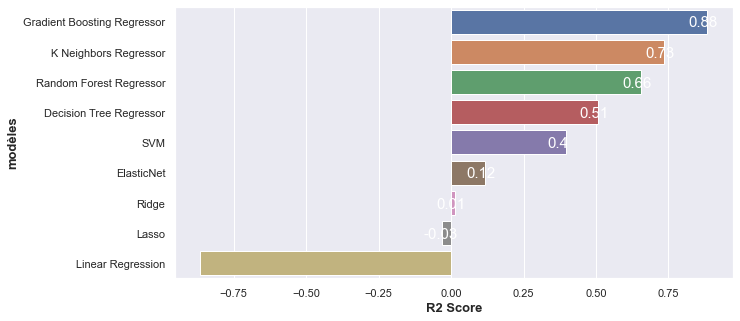

In [37]:
sns.set(rc={'figure.figsize':(14,14)})
plt.figure(figsize=(10, 5))

img=sns.barplot(x=df_scores['R2'],
                       y=df_scores['modele']
                       ) 
for p in img.patches:
    img.annotate(format(round(p.get_width(),2)),
                      (p.get_width() - 0.1, p.get_y() + 0.1 + p.get_height()),
                      color='#ffffff',
                      fontsize=15,
                      xytext=(10, 10),
                      textcoords='offset points')
    
plt.ylabel('modèles', size=13, weight='bold')
plt.xlabel('R2 Score', size=13, weight='bold')

De ceci, on peut dire que les meilleurs modeles pour la prediction de la consomation d'energie est le model Gradient Boosting Regressor, Random Forest et K Neighbors Regressor, etant le model Gradient Boosting Regressor le plus performant. Dans la suite on realisera une comparaison entre ces modeles afin de determiner le temps qu'il prendra a son entrainement et execution, pour cela on prendra les meilleurs HyperParametres que la methode GridSearchCV nous a donné, qui sont les suivants:

    a)GradientBoostingRegressor() {'max_depth': 9, 'max_features': 'log2'}
    b)RandomForestRegressor() {'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1}
    c)KNeighborsRegressor() {'metric': 'euclidean', 'n_neighbors': 3}

### 1.5) Modeles utilisez

In [38]:
K_Neighbors_Regressor=KNeighborsRegressor(metric='euclidean',n_neighbors=3)
Random_Forest_Regressor=RandomForestRegressor(max_depth=12,max_features='log2',min_samples_leaf=1)
Gradient_Boosting_Regressor=GradientBoostingRegressor(max_depth=9,max_features='log2')

In [39]:
model_energie = [ K_Neighbors_Regressor, Random_Forest_Regressor, Gradient_Boosting_Regressor]
nom_model=['K Neighbors Regressor','Random Forest Regressor','Gradient Boosting Regressor']

### 1.5.1) Evaluation des modeles avec R2 score

In [40]:
evaluation_models = []
evaluation_model=pd.DataFrame(evaluation_models,columns=['modele', 'R2', 'RMCE', 'MAE'])

for model in model_energie:
    model_info = model_evaluation(model,evaluation_model)
    

In [41]:
evaluation_model

,modele,R2,RMCE,MAE
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.811874,0.010725,0.002437
1,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.791220,0.011299,0.002470
2,"KNeighborsRegressor(metric='euclidean', n_neig...",0.734673,0.012737,0.002983


In [42]:
evaluation_model['modele']=['Gradient Boosting Regressor','Random Forest Regressor','K Neighbors Regressor']

In [43]:
evaluation_model

,modele,R2,RMCE,MAE
0,Gradient Boosting Regressor,0.811874,0.010725,0.002437
1,Random Forest Regressor,0.791220,0.011299,0.002470
2,K Neighbors Regressor,0.734673,0.012737,0.002983


Text(0.5, 0, 'R2 Score')

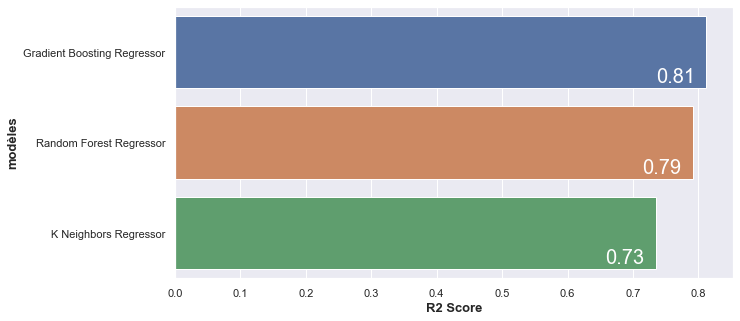

In [55]:
sns.set(rc={'figure.figsize':(14,14)})
plt.figure(figsize=(10, 5))

img=sns.barplot(x=evaluation_model['R2'],
                       y=evaluation_model['modele']
                       ) 
for p in img.patches:
    img.annotate(format(round(p.get_width(),2)),
                      (p.get_width() - 0.1, p.get_y() + 0.05 + p.get_height()),
                      color='#ffffff',
                      fontsize=20,
                      xytext=(15, 10),
                      textcoords='offset points')
    
plt.ylabel('modèles', size=13, weight='bold')
plt.xlabel('R2 Score', size=13, weight='bold')

### 1.5.2) Evaluation de la robustesses des modeles 

In [56]:
cross_validation = []
for models in model_energie:
    cross_val = validation_croise(models,X_train, y_train)
    cross_validation.append(cross_val)

val_cross=pd.DataFrame(cross_validation,columns=['R2(0)','R2(1)','R2(2)','R2(3)','R2(4)'])
val_cross['nom']=nom_model

In [57]:
val_cross

,R2(0),R2(1),R2(2),R2(3),R2(4),nom
0,0.837365,0.023689,0.899336,0.745108,0.235002,K Neighbors Regressor
1,0.835509,0.835893,0.392821,0.796441,0.316366,Random Forest Regressor
2,0.855321,0.889948,-0.483646,0.847682,0.279756,Gradient Boosting Regressor


### 1.5.3) Evaluation du Temps d'entrenaiment

In [58]:
models = [{"name": "K neighbors Regressor", "clf": K_Neighbors_Regressor},
          {"name": "Gradient Boosting Regressor", "clf": Gradient_Boosting_Regressor},  
          {"name": "Random Forest Regressor", "clf": Random_Forest_Regressor}]

In [59]:
trained_models = []
for model in models:
    model_details = train_model(model)
    trained_models.append(model_details)
    
model_entrene=pd.DataFrame(trained_models)

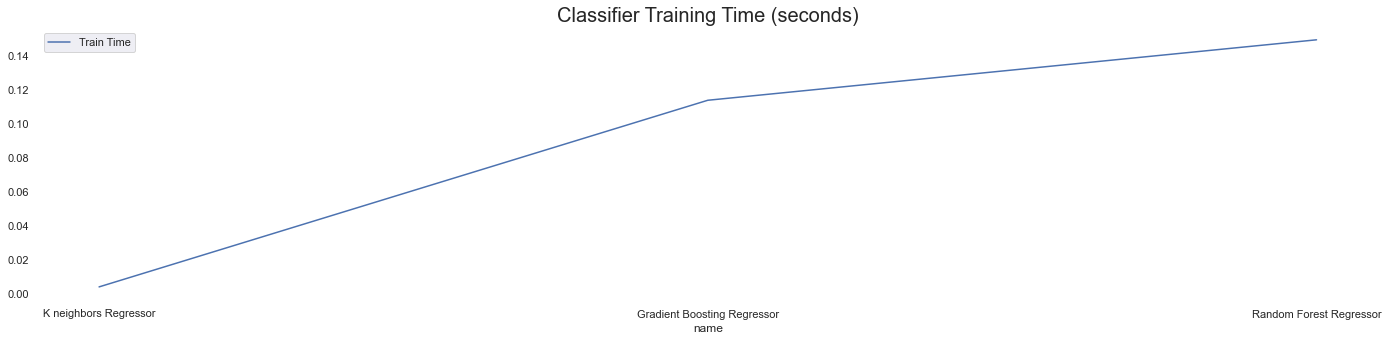

In [60]:
model_df = pd.DataFrame(trained_models)
model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(24,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)  

## 2) Etude de l'emission de CO2 avec la variable ENERGYSTARScore

In [61]:
df_emission_score=df.copy()
df_emission_score=df_emission_score.dropna(axis = 0)

### 2.1) Standardisation

In [62]:
column=df_emission_score.columns.values
scaler = MinMaxScaler()
scaler.fit(df_emission_score)
df_np=scaler.transform(df_emission_score)

In [63]:
df_test=pd.DataFrame(df_np,columns=column)

In [64]:
remove_column(df_test,['SiteEnergyUse','SteamUse','NaturalGas','BuildingRate','HistoricalPeriod'])

### 2.2) Echantillonage

In [65]:
trainset, testset = train_test_split(df_test, test_size=0.2, random_state=0)

In [66]:
X_train, y_train = preprocessing(trainset,'TotalGHGEmissions')

In [67]:
X_test, y_test = preprocessing(testset,'TotalGHGEmissions')

### 2.3) Test du meilleur model

In [68]:
best=[]
df_best = pd.DataFrame(
    best, columns=['modele', 'R2', 'RMSE', 'MCE'])
model_evaluation(Gradient_Boosting_Regressor,df_best)

,modele,R2,RMSE,MCE
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.873296,0.008802,0.002285


In [69]:
model_evaluation(Random_Forest_Regressor,df_best)

,modele,R2,RMSE,MCE
0,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.886139,0.008344,0.002509
1,([DecisionTreeRegressor(criterion='friedman_ms...,0.873296,0.008802,0.002285


In [70]:
model_evaluation(K_Neighbors_Regressor,df_best)

,modele,R2,RMSE,MCE
0,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.886139,0.008344,0.002509
1,([DecisionTreeRegressor(criterion='friedman_ms...,0.873296,0.008802,0.002285
2,"KNeighborsRegressor(metric='euclidean', n_neig...",0.273488,0.021077,0.002714


In [71]:
df_best['modele']=['Random Forest Regressor','Gradient Boosting Regressor','K Neighbors Regressor']
df_best

,modele,R2,RMSE,MCE
0,Random Forest Regressor,0.886139,0.008344,0.002509
1,Gradient Boosting Regressor,0.873296,0.008802,0.002285
2,K Neighbors Regressor,0.273488,0.021077,0.002714


Text(0.5, 0, 'R2 Score')

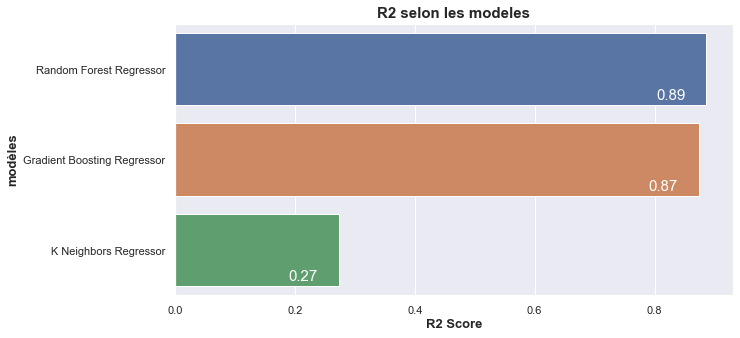

In [75]:
sns.set(rc={'figure.figsize':(14,14)})
plt.figure(figsize=(10, 5))

img=sns.barplot(x=df_best['R2'],
                       y=df_best['modele']
                       ) 
for p in img.patches:
    img.annotate(format(round(p.get_width(),2)),
                      (p.get_width() - 0.1, p.get_y() + 0.05 + p.get_height()),
                      color='#ffffff',
                      fontsize=15,
                      xytext=(10, 10),
                      textcoords='offset points')
    
plt.title('R2 selon les modeles', size=15, weight='bold')
plt.ylabel('modèles', size=13, weight='bold')
plt.xlabel('R2 Score', size=13, weight='bold')

Comme on observe ci-dessus, l'influence de la varibale ENERGYSTARScore n'est pas negligeable, la probabilité de prediction du modele Random forest est fortement augmené passant de 0.79 dans la section precendente a 0.89 d'accertivité. De même pour le modele Gradient Boosting Regressor qui a monté sa probabilité de prediction de 0.81 a 0.87. Par contre sur le model KNeighbors Regressor il a une influence negative, faisant reduire sa capacité de prediction jusqu'a 0.27. 

## 2.4) Etude de l'influence des variables par rapport aux modeles

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Intercept 0.09659805163426681
Prediction_local [0.0676749]
Right: 0.03604759880750403


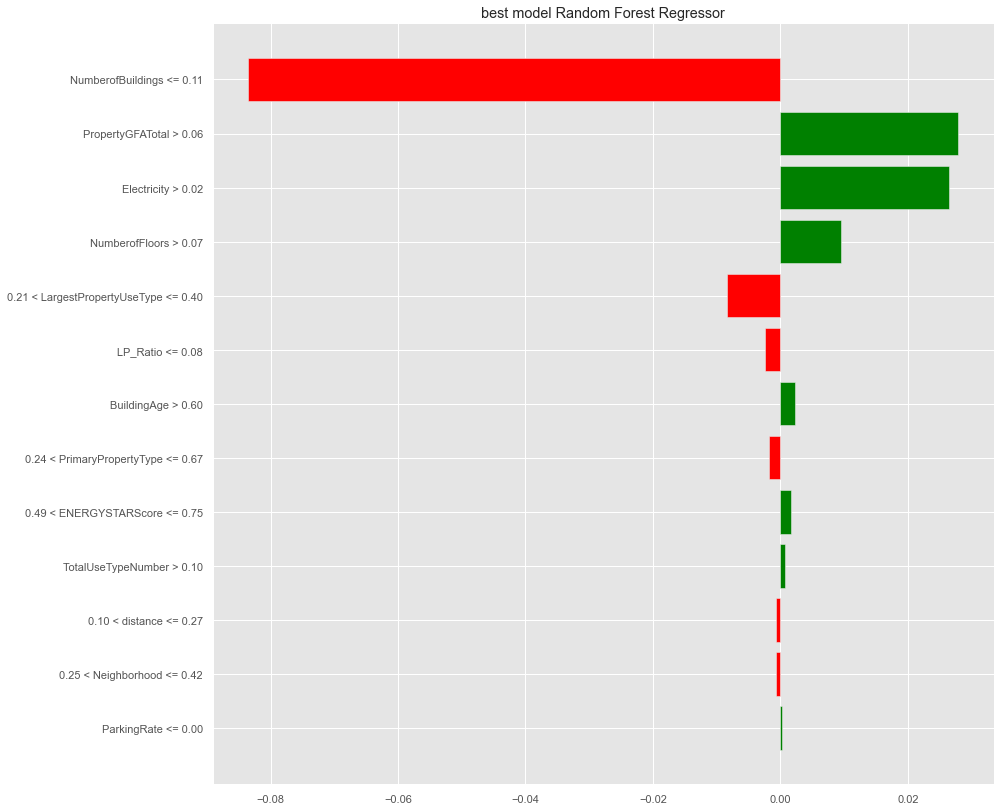

In [77]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')
exp = explainer.explain_instance(X_test.values[100], Random_Forest_Regressor.predict, num_features=len(X_train.columns.values.tolist()))
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.title('best model Random Forest Regressor')

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


Intercept 0.06213978083417035
Prediction_local [0.07351148]
Right: 0.03827170326385785


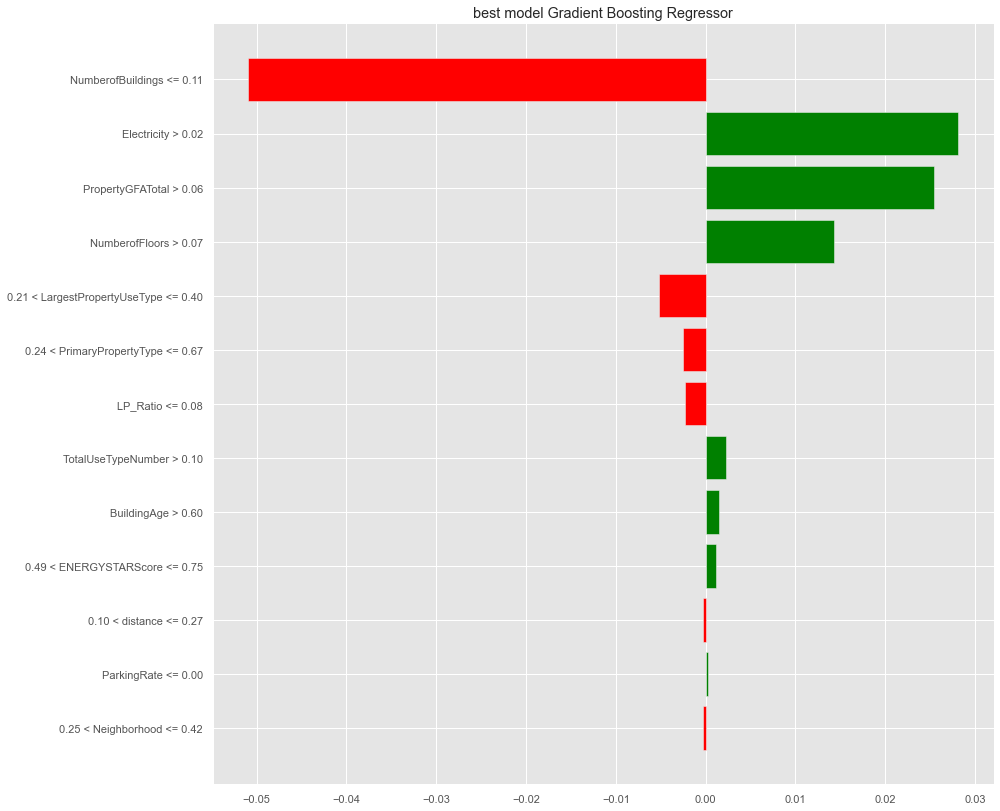

In [78]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')
exp = explainer.explain_instance(X_test.values[100], Gradient_Boosting_Regressor.predict, num_features=len(X_train.columns.values.tolist()))
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.title('best model Gradient Boosting Regressor')

Comme on peut observer ci-dessus, la variable ENERGYSTARScore a une influence positive sur nos modeles